<h1>**Table of Contents**<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-engineering---quantifying-access-to-facilities---batch-mode" data-toc-modified-id="Feature-engineering---quantifying-access-to-facilities---batch-mode-1">Feature engineering - quantifying access to facilities - batch mode</a></span><ul class="toc-item"><li><span><a href="#Read-the-shortlisted-properties" data-toc-modified-id="Read-the-shortlisted-properties-1.1">Read the shortlisted properties</a></span></li><li><span><a href="#Loop-through-each-property-and-build-the-neighborhood-facility-table" data-toc-modified-id="Loop-through-each-property-and-build-the-neighborhood-facility-table-1.2">Loop through each property and build the neighborhood facility table</a></span></li><li><span><a href="#Feature-engineer-with-access-to-amenities" data-toc-modified-id="Feature-engineer-with-access-to-amenities-1.3">Feature engineer with access to amenities</a></span><ul class="toc-item"><li><span><a href="#Plot-the-distribution-of-facility-access" data-toc-modified-id="Plot-the-distribution-of-facility-access-1.3.1">Plot the distribution of facility access</a></span></li><li><span><a href="#Store-to-disk" data-toc-modified-id="Store-to-disk-1.3.2">Store to disk</a></span></li></ul></li></ul></li></ul></div>

# Feature engineering - quantifying access to facilities - batch mode
This notebook is similar to previous (04_feature-engineering-neighboring-facilities), except, this one runs for all shortlisted facilities and adds these as features.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline

from arcgis.gis import GIS
from arcgis.geocoding import geocode, batch_geocode
from arcgis.features import Feature, FeatureLayer, FeatureSet, GeoAccessor, GeoSeriesAccessor
from arcgis.features import SpatialDataFrame
from arcgis.geometry import Geometry, Point
from arcgis.geometry.functions import buffer
from arcgis.network import RouteLayer

Connect to GIS

In [7]:
gis = GIS(profile='')
route_service_url = gis.properties.helperServices.route.url
route_service = RouteLayer(route_service_url, gis=gis)

## Read the shortlisted properties

In [3]:
prop_list_df = pd.read_csv('resources/houses_for_sale_att_filtered.csv')
prop_list_df.shape

(331, 24)

In [4]:
prop_list_df = pd.DataFrame.spatial.from_xy(prop_list_df, 'LONGITUDE','LATITUDE')
type(prop_list_df)

pandas.core.frame.DataFrame

## Loop through each property and build the neighborhood facility table

In [10]:
groceries_count = []
restaurants_count = []
hospitals_count = []
coffee_count = []
bars_count = []
gas_count = []
shops_service_count = []
travel_transport_count = []
parks_count = []
education_count = []
route_length = []
route_duration = []

destination_address = '309 SW 6th Ave #600, Portland, OR 97204'

In [12]:
count=0
for index, prop in prop_list_df.iterrows():
    count+=1
    print(str(count), end=": ")
    # geocode the property
    paddress = prop['ADDRESS'] + ", " + prop['CITY'] + ", " + prop['STATE']
    prop_geom_fset = geocode(paddress, as_featureset=True)
    
    print(prop['MLS'], end=" : ")
    
    # create an envelope around each property
    prop_geom = prop_geom_fset.features[0]
    
    # create buffer of 5 miles
    prop_buffer = buffer([prop_geom.geometry], 
                     in_sr = 102100, buffer_sr=102100,
                     distances=0.05, unit=9001)[0]

    prop_buffer_f = Feature(geometry=prop_buffer)
    prop_buffer_fset = FeatureSet([prop_buffer_f])
    
    # geocode for Groceries
    groceries = geocode('groceries', search_extent=prop_buffer.extent, 
                    max_locations=20, as_featureset=True)
    groceries_count.append(len(groceries.features))
    print('Groc', end=" : ")
    
    # restaurants
    restaurants = geocode('restaurant', search_extent=prop_buffer.extent, max_locations=200)
    restaurants_count.append(len(restaurants))
    print('Rest', end=" : ")
    
    # hospitals
    hospitals = geocode('hospital', search_extent=prop_buffer.extent, max_locations=50)
    hospitals_count.append(len(hospitals))
    print('Hosp', end =" : ")
    
    # coffee shop
    coffees = geocode('coffee', search_extent=prop_buffer.extent, max_locations=50)
    coffee_count.append(len(coffees))
    print('Coffee', end=" : ")
    
    # bars
    bars = geocode('bar', search_extent=prop_buffer.extent, max_locations=50)
    bars_count.append(len(bars))
    print('Bars', end=" : ")
    
    # gas stations
    gas = geocode('gas station', search_extent=prop_buffer.extent, max_locations=50)
    gas_count.append(len(gas))
    print('Gas', end=" : ")
    
    # shops
    shops_service = geocode("",category='shops and service', 
                            search_extent=prop_buffer.extent, max_locations=50)
    shops_service_count.append(len(shops_service))
    print('Shops', end=" : ")
    
    # travel & transport
    transport = geocode("",category='travel and transport', 
                        search_extent=prop_buffer.extent, max_locations=50)
    travel_transport_count.append(len(transport))
    print("Travel", end =" : ")
    
    # parks
    parks = geocode("",category='parks and outdoors', 
                    search_extent=prop_buffer.extent, max_locations=50)
    parks_count.append(len(parks))
    print('Parks', end=" : ")
    
    # education
    education = geocode("",category='education', search_extent=prop_buffer.extent, 
                        max_locations=50)
    education_count.append(len(education))
    print("Edu", end=" : ")
    
    # get route
    stops = [paddress, destination_address]
    stops_geocoded = batch_geocode(stops)

    stops_geocoded = [item['location'] for item in stops_geocoded]
    stops_geocoded2 = '{},{};{},{}'.format(stops_geocoded[0]['x'],stops_geocoded[0]['y'],
                                           stops_geocoded[1]['x'],stops_geocoded[1]['y'])

    route_result = route_service.solve(stops_geocoded2, return_routes=True, 
                             return_stops=False, return_directions=True,
                             impedance_attribute_name='TravelTime',
                             start_time=644511600000,
                             return_barriers=False, return_polygon_barriers=False,
                             return_polyline_barriers=False)
    route_length.append(route_result['directions'][0]['summary']['totalLength'])
    route_duration.append(route_result['directions'][0]['summary']['totalTime'])
    print("Route")

1: 18517652 : Groc : Rest : Hosp : Coffee : Bars : Gas : Shops : Travel : Parks : Edu : Route
2: 18465613 : Groc : Rest : Hosp : Coffee : Bars : Gas : Shops : Travel : Parks : Edu : Route
3: 18005102 : Groc : Rest : Hosp : Coffee : Bars : Gas : Shops : Travel : Parks : Edu : Route
4: 18216924 : Groc : Rest : Hosp : Coffee : Bars : Gas : Shops : Travel : Parks : Edu : Route
5: 18647164 : Groc : Rest : Hosp : Coffee : Bars : Gas : Shops : Travel : Parks : Edu : Route
6: 18229660 : Groc : Rest : Hosp : Coffee : Bars : Gas : Shops : Travel : Parks : Edu : Route
7: 18586790 : Groc : Rest : Hosp : Coffee : Bars : Gas : Shops : Travel : Parks : Edu : Route
8: 18314898 : Groc : Rest : Hosp : Coffee : Bars : Gas : Shops : Travel : Parks : Edu : Route
9: 18085278 : Groc : Rest : Hosp : Coffee : Bars : Gas : Shops : Travel : Parks : Edu : Route
10: 18406186 : Groc : Rest : Hosp : Coffee : Bars : Gas : Shops : Travel : Parks : Edu : Route
11: 18020972 : Groc : Rest : Hosp : Coffee : Bars : Gas : S

172: 18187676 : Groc : Rest : Hosp : Coffee : Bars : Gas : Shops : Travel : Parks : Edu : Route
173: 18521135 : Groc : Rest : Hosp : Coffee : Bars : Gas : Shops : Travel : Parks : Edu : Route
174: 18661709 : Groc : Rest : Hosp : Coffee : Bars : Gas : Shops : Travel : Parks : Edu : Route
175: 18196732 : Groc : Rest : Hosp : Coffee : Bars : Gas : Shops : Travel : Parks : Edu : Route
176: 18047304 : Groc : Rest : Hosp : Coffee : Bars : Gas : Shops : Travel : Parks : Edu : Route
177: 18202505 : Groc : Rest : Hosp : Coffee : Bars : Gas : Shops : Travel : Parks : Edu : Route
178: 18090694 : Groc : Rest : Hosp : Coffee : Bars : Gas : Shops : Travel : Parks : Edu : Route
179: 18572038 : Groc : Rest : Hosp : Coffee : Bars : Gas : Shops : Travel : Parks : Edu : Route
180: 18641153 : Groc : Rest : Hosp : Coffee : Bars : Gas : Shops : Travel : Parks : Edu : Route
181: 18231117 : Groc : Rest : Hosp : Coffee : Bars : Gas : Shops : Travel : Parks : Edu : Route
182: 18069841 : Groc : Rest : Hosp : Cof

## Feature engineer with access to amenities

In [29]:
prop_list_df['grocery_count'] = groceries_count
prop_list_df['restaurant_count']= restaurants_count
prop_list_df['hospitals_count']= hospitals_count
prop_list_df['coffee_count']= coffee_count
prop_list_df['bars_count']=bars_count
prop_list_df['gas_count']=gas_count
prop_list_df['shops_count']=shops_service_count
prop_list_df['travel_count']=travel_transport_count
prop_list_df['parks_count']=parks_count
prop_list_df['edu_count']=education_count
prop_list_df['commute_length']=route_length
prop_list_df['commute_duration']=route_duration
prop_list_df.head()

,Unnamed: 0,SALE TYPE,PROPERTY TYPE,ADDRESS,CITY,STATE,ZIP,PRICE,BEDS,BATHS,...,hospitals_count,coffee_count,bars_count,gas_count,shops_count,travel_count,parks_count,edu_count,commute_length,commute_duration
0,618,MLS Listing,Single Family Residential,144 SE 191st Pl,Portland,OR,97233.0,334900.0,4.0,2.5,...,0,19,0,28,41,50,50,50,13.978589,25.621265
1,776,MLS Listing,Single Family Residential,20028 NE Hoyt St,Portland,OR,97230.0,349950.0,3.0,2.5,...,2,23,0,31,38,50,50,50,13.913465,24.726944
2,808,MLS Listing,Single Family Residential,711 SE 160th Ave,Portland,OR,97233.0,358999.0,4.0,2.5,...,0,16,0,34,47,50,50,50,14.644863,27.830024
3,881,MLS Listing,Single Family Residential,5536 SE 142nd Pl,Portland,OR,97236.0,369800.0,4.0,2.5,...,2,18,0,29,45,48,50,50,13.097669,25.943438
4,955,MLS Listing,Single Family Residential,15707 SE Flavel Dr,Portland,OR,97236.0,379900.0,3.0,2.0,...,0,13,0,17,44,10,50,41,14.254413,28.403598


### Plot the distribution of facility access

In [33]:
prop_list_df.columns

Index(['Unnamed: 0', 'SALE TYPE', 'PROPERTY TYPE', 'ADDRESS', 'CITY', 'STATE',
       'ZIP', 'PRICE', 'BEDS', 'BATHS', 'LOCATION', 'SQUARE FEET', 'LOT SIZE',
       'YEAR BUILT', 'DAYS ON MARKET', 'PRICE PER SQFT', 'HOA PER MONTH',
       'STATUS', 'URL', 'SOURCE', 'MLS', 'LATITUDE', 'LONGITUDE', 'SHAPE',
       'grocery_count', 'restaurant_count', 'hospitals_count', 'coffee_count',
       'bars_count', 'gas_count', 'shops_count', 'travel_count', 'parks_count',
       'edu_count', 'commute_length', 'commute_duration'],
      dtype='object')

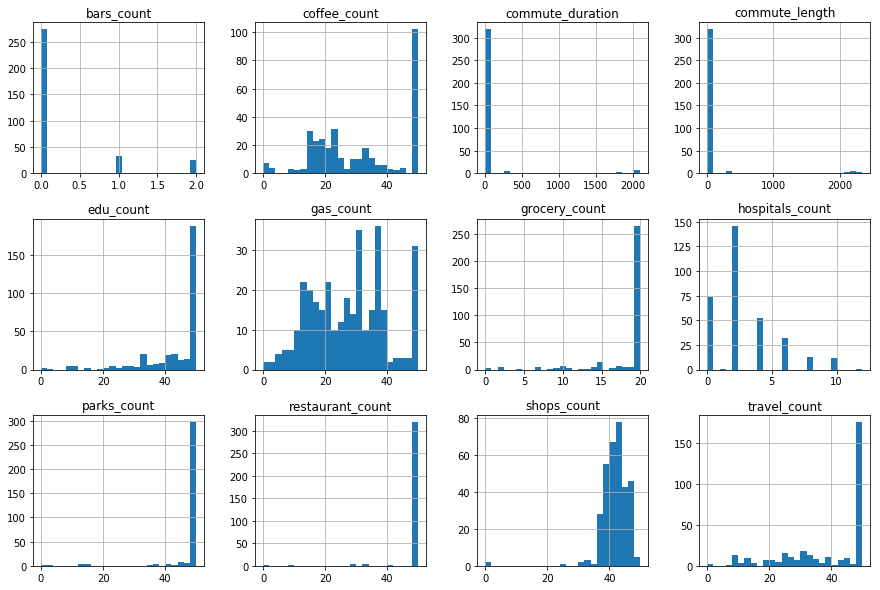

In [37]:
facility_list = ['grocery_count', 'restaurant_count', 'hospitals_count', 'coffee_count',
       'bars_count', 'gas_count', 'shops_count', 'travel_count', 'parks_count',
       'edu_count', 'commute_length', 'commute_duration']

axes = prop_list_df[facility_list].hist(bins=25, layout=(3,4), figsize=(15,10))

From the histograms above, most houses don't have very many bars in 5 miles around them. The commute length and duration appears to be tightly clustered around the lower end of the spectrum. Most houses have at least 1 hospital or medical center near them and a large number of parks, restaurants, educational institutions.

### Store to disk

In [30]:
prop_list_df.to_csv('resources/houses_facility_counts.csv')
prop_list_df.spatial.to_featureclass('resources/shp/houses_facility_counts.shp')

'resources/shp/houses_facility_counts.shp'